<a href="https://colab.research.google.com/github/VivekKejriwal/TheSchoolOfAI/blob/main/Assignment_5/Step1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install torch
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn.functional as F

In [2]:
#REQUIRED TRANSFORMS CREATED

train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((.1307,),(0.3081,))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((.1307,),(0.3081,))
])

In [3]:
#LOADING REQUIRED MNIST DATA

train = datasets.MNIST('./data',download=True,train=True,transform= train_transforms)
test  = datasets.MNIST('./data',download=True,train=False,transform= test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
SEED = 1

#CUDA?
cuda = torch.cuda.is_available()
#print(cuda)

torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size = 128, num_workers=4,pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

#train loader

train_loader = torch.utils.data.DataLoader(train,**dataloader_args)

#test loader

test_loader = torch.utils.data.DataLoader(test,**dataloader_args)

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
Numpy shape:  torch.Size([28, 60000, 28])
Tensor size:  torch.Size([60000, 28, 28])
min:  tensor(-0.4242)
max:  tensor(2.8215)
mean:  tensor(-0.0001)
variance:  tensor(1.0001)
standard deviation:  tensor(1.0000)
torch.Size([128, 1, 28, 28])
torch.Size([128])


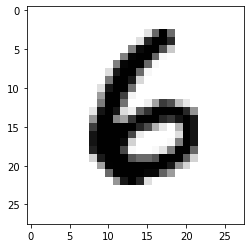

In [5]:
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print("[Train]")
print("Numpy shape: ",train_data.shape)
print("Tensor size: ",train.train_data.shape)
print("min: ",torch.min(train_data))
print("max: ",torch.max(train_data))
print("mean: ",torch.mean(train_data))
print("variance: ",torch.var(train_data))
print("standard deviation: ",torch.std(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


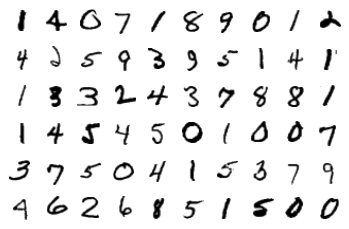

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1,num_of_images+1):
  plt.subplot(6,10,index)
  plt.axis('off')
  plt.imshow(images[index].numpy().squeeze(),cmap='gray_r') 

In [7]:
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()

    self.conv1 = nn.Sequential(
        nn.Conv2d(1,32,3,padding=1), #input- 28X28X1 Output - 28X28X32 RF 3
        nn.ReLU(),
        nn.Conv2d(32,64,3,padding=1),#input- 28X28X32 Output - 28X28X64 RF 5
        nn.ReLU(),
        nn.MaxPool2d(2,2)  #RF-6
    )

    self.conv2 = nn.Sequential(
        nn.Conv2d(64,64,3,padding=1), #input- 14X14X64 Output - 14X14X64 RF-10
        nn.ReLU(),
        nn.Conv2d(64,128,3,padding=1),#input- 14X14X64 Output - 14X14X128 RF- 14
        nn.ReLU(),
        nn.MaxPool2d(2,2) #RF - 16
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(128,256,3), #input- 7X7X128 Output - 5X5X256 RF- 24
        nn.ReLU(),
        nn.Conv2d(256,512,3), #input- 5X5X256 Output - 3X3X512 RF- 32
        nn.ReLU(),
        nn.Conv2d(512,10,3)   #input- 3X3X512 Output - 1X1X10 RF- 40
    )

  def forward(self,x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = x.view(-1,10)
    return F.log_softmax(x, dim=1)


In [8]:
!pip install torchsummary

from torchsummary import summary

device = torch.device("cuda" if cuda else "cpu")
print(device)

model = Net().to(device)
summary(model, input_size = (1, 28, 28))


cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
            Conv2d-3           [-1, 64, 28, 28]          18,496
              ReLU-4           [-1, 64, 28, 28]               0
         MaxPool2d-5           [-1, 64, 14, 14]               0
            Conv2d-6           [-1, 64, 14, 14]          36,928
              ReLU-7           [-1, 64, 14, 14]               0
            Conv2d-8          [-1, 128, 14, 14]          73,856
              ReLU-9          [-1, 128, 14, 14]               0
        MaxPool2d-10            [-1, 128, 7, 7]               0
           Conv2d-11            [-1, 256, 5, 5]         295,168
             ReLU-12            [-1, 256, 5, 5]               0
           Conv2d-13            [-1, 512, 3, 3]       1,180,160
             ReLU-14            [-

In [9]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model,device,train_loader,optimizer,epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  
  for batch_id,(data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    y_pred = model(data)

    loss= F.nll_loss(y_pred,target)
    train_losses.append(loss)

    loss.backward()
    optimizer.step()

    pred = y_pred.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed+= len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_size={batch_id} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model,device,test_loader):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss = F.nll_loss(output, target, reduction='sum').item()
      pred = output.argmax(dim= 1,keepdim=True)
      correct+= pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)

  print('\nTest set: Average loss: {:.4f}, Acccuracy= {}/{} ({:.2f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100.*correct/len(test_loader.dataset)))
  
  test_acc.append(100.*correct/len(test_loader.dataset))



In [10]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(),lr=0.01,momentum=0.9)

EPOCHS = 20

for epoch in range(EPOCHS):
  print("EPOCH: ",epoch)
  train(model,device,train_loader,optimizer,epoch)
  test (model,device,test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH:  0


Loss=0.08278658241033554 Batch_size=468 Accuracy=84.89: 100%|██████████| 469/469 [00:14<00:00, 32.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9794/10000 (97.94%)

EPOCH:  1


Loss=0.060709547251462936 Batch_size=468 Accuracy=98.09: 100%|██████████| 469/469 [00:14<00:00, 32.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Acccuracy= 9850/10000 (98.50%)

EPOCH:  2


Loss=0.05248567834496498 Batch_size=468 Accuracy=98.78: 100%|██████████| 469/469 [00:14<00:00, 32.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9867/10000 (98.67%)

EPOCH:  3


Loss=0.011919564567506313 Batch_size=468 Accuracy=99.13: 100%|██████████| 469/469 [00:14<00:00, 32.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9909/10000 (99.09%)

EPOCH:  4


Loss=0.07815547287464142 Batch_size=468 Accuracy=99.31: 100%|██████████| 469/469 [00:14<00:00, 32.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Acccuracy= 9892/10000 (98.92%)

EPOCH:  5


Loss=0.011764002032577991 Batch_size=468 Accuracy=99.48: 100%|██████████| 469/469 [00:14<00:00, 32.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9878/10000 (98.78%)

EPOCH:  6


Loss=0.002526073483750224 Batch_size=468 Accuracy=99.60: 100%|██████████| 469/469 [00:14<00:00, 32.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9908/10000 (99.08%)

EPOCH:  7


Loss=0.007340676616877317 Batch_size=468 Accuracy=99.65: 100%|██████████| 469/469 [00:14<00:00, 31.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9923/10000 (99.23%)

EPOCH:  8


Loss=0.0008371579460799694 Batch_size=468 Accuracy=99.74: 100%|██████████| 469/469 [00:14<00:00, 32.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9906/10000 (99.06%)

EPOCH:  9


Loss=0.0018312102183699608 Batch_size=468 Accuracy=99.81: 100%|██████████| 469/469 [00:14<00:00, 32.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9885/10000 (98.85%)

EPOCH:  10


Loss=0.0018895585089921951 Batch_size=468 Accuracy=99.82: 100%|██████████| 469/469 [00:14<00:00, 32.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9907/10000 (99.07%)

EPOCH:  11


Loss=0.0005102956783957779 Batch_size=468 Accuracy=99.81: 100%|██████████| 469/469 [00:14<00:00, 32.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9915/10000 (99.15%)

EPOCH:  12


Loss=0.0013867175439372659 Batch_size=468 Accuracy=99.90: 100%|██████████| 469/469 [00:14<00:00, 32.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9916/10000 (99.16%)

EPOCH:  13


Loss=0.0009058992727659643 Batch_size=468 Accuracy=99.91: 100%|██████████| 469/469 [00:14<00:00, 32.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9930/10000 (99.30%)

EPOCH:  14


Loss=0.0006626269314438105 Batch_size=468 Accuracy=99.97: 100%|██████████| 469/469 [00:14<00:00, 32.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9913/10000 (99.13%)

EPOCH:  15


Loss=0.00021145310893189162 Batch_size=468 Accuracy=99.95: 100%|██████████| 469/469 [00:14<00:00, 32.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9927/10000 (99.27%)

EPOCH:  16


Loss=0.0005327624967321754 Batch_size=468 Accuracy=99.89: 100%|██████████| 469/469 [00:14<00:00, 31.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9916/10000 (99.16%)

EPOCH:  17


Loss=0.0004775553534273058 Batch_size=468 Accuracy=99.91: 100%|██████████| 469/469 [00:14<00:00, 32.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Acccuracy= 9915/10000 (99.15%)

EPOCH:  18


Loss=0.000665843253955245 Batch_size=468 Accuracy=99.93: 100%|██████████| 469/469 [00:14<00:00, 32.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9922/10000 (99.22%)

EPOCH:  19


Loss=0.00045126312761567533 Batch_size=468 Accuracy=99.97: 100%|██████████| 469/469 [00:14<00:00, 32.85it/s]



Test set: Average loss: 0.0000, Acccuracy= 9917/10000 (99.17%)



Text(0.5, 1.0, 'Test Accuracy')

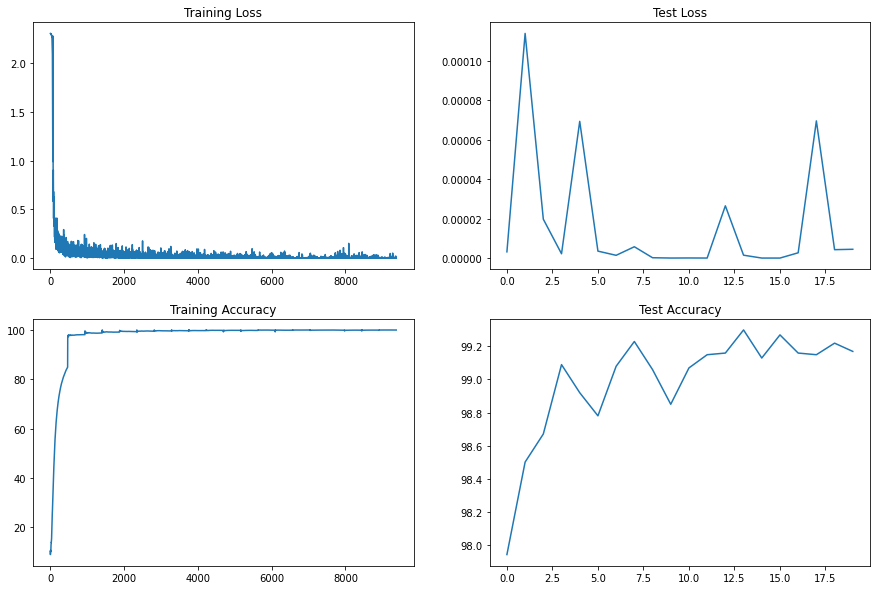

In [12]:
fig, axs = plt.subplots(2,2, figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

Target:

    Get the set-up right
    Set Transforms
    Set Data Loader
    Set Basic Working Code
    Set Basic Training  & Test Loop

Results:

    Parameters: 1.6M
    Best Training Accuracy: 99.97
    Best Test Accuracy: 99.30

Analysis:

    Extremely Heavy Model for such a problem
    Model is over-fitting, but we are changing our model in the next step
